# DeepLab

Tutorial notebook

In [18]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random
import torch
torch.cuda.set_device(0)
import numpy as np
import cv2
import PIL
from PIL import Image, ImageOps

In [19]:
import sys
sys.path.insert(1, '../utils/')
from kfold import *
sys.path.insert(1, '../utils/')
from metrics import *

### We set a random seed for reproducibility

In [20]:
number_of_the_seed = 2020
random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
path=Path('../dataset')
path_train=path/'train'
files=[path_train/f for f in os.listdir(path_train)]

### We show some images and its mask

<Axes: >

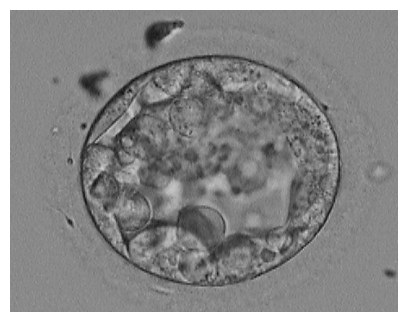

In [5]:
img = PILImage.create(files[1])
img.show(figsize=(5, 5))

In [6]:
get_y_fn = lambda x: Path(str(x).replace("train","GT_Mask"))

<Axes: >

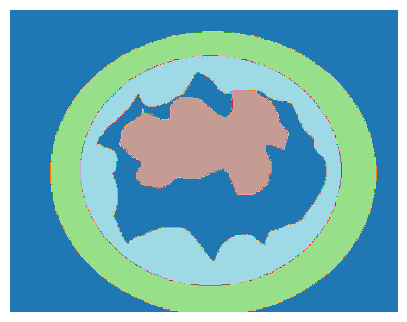

In [7]:
mask = PILMask.create(get_y_fn(files[1]))
mask.show(figsize=(5, 5), alpha=1)

### Setting some transformormations for data augmentation

In [13]:
from albumentations import (Compose,OneOf,ElasticTransform,GridDistortion, OpticalDistortion,HorizontalFlip,Rotate,Transpose,CLAHE,ShiftScaleRotate)
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [14]:
transforms=Compose([HorizontalFlip(p=0.5),Rotate(p=0.40,limit=10)],p=1)
transformPipeline=SegmentationAlbumentationsTransform(transforms)

### Transforming our  Ground Truth masks

In [15]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        # {'TE':255, 'ICM':150,'ZP':75}
        mask[mask==0]=0
        mask[mask==75]=1
        mask[mask==255]=2
        mask[mask==150]=3     
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [16]:
codes = np.array(['Background','ZP', 'TE', 'ICM'])

### Datablock

In [17]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((480,480)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

In [18]:
bs = 2
path_images=path_train
trainDLS = trainDB.dataloaders(path_images,bs=bs)

### Setting the accuracy for each structure

In [19]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def zp(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def te(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def icm(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

## Training

### Define the model

**model**: deeplabv3+

**backbone**: resnet50

In [20]:
learn = get_segmentation_learner(dls=trainDLS, number_classes=4, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[background,zp,te,icm,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

#### Find learning rate

SuggestedLRs(valley=0.00363078061491251)

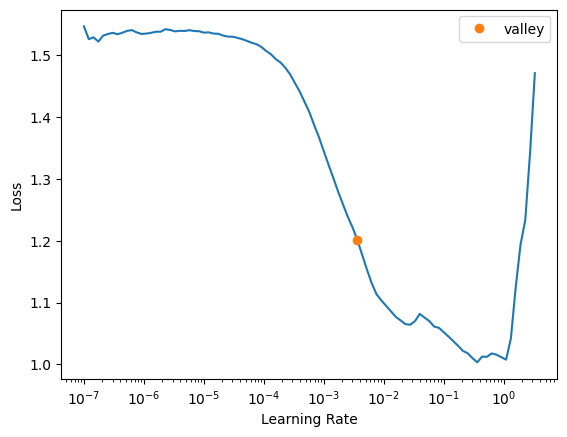

In [21]:
learn.lr_find()

#### Set the callbacks before unfreeze

In [ ]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2

fname="../models/deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [ShowGraphCallback(), EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
                              SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]

#### Train for 20 epochs

epoch,train_loss,valid_loss,background,zp,te,icm,msa,time
0,1.004982,0.978223,0.650346,0.728886,0.694181,0.685505,0.695771,00:20
1,0.770231,0.677079,0.784729,0.830020,0.830612,0.815118,0.820968,00:21
2,0.524691,0.409584,0.843749,0.882057,0.888589,0.880927,0.879744,00:25
3,0.388602,0.328738,0.817935,0.887107,0.904262,0.892384,0.886540,00:22
4,0.313959,0.283519,0.817864,0.909994,0.911607,0.896690,0.895822,00:20
5,0.262351,0.270757,0.788854,0.919980,0.910618,0.903221,0.896624,00:21
6,0.231401,0.258010,0.869237,0.903656,0.907372,0.903714,0.902164,00:20
7,0.205983,0.252911,0.859579,0.908720,0.911019,0.904127,0.903083,00:21
8,0.177728,0.231288,0.874028,0.911460,0.930399,0.910966,0.912884,00:23
9,0.168891,0.230130,0.855498,0.921755,0.918417,0.912440,0.910374,00:21


Better model found at epoch 0 with valid_loss value: 0.9782232642173767.


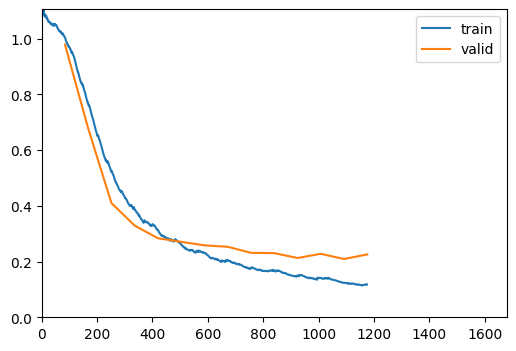

Better model found at epoch 1 with valid_loss value: 0.6770787239074707.
Better model found at epoch 2 with valid_loss value: 0.40958428382873535.
Better model found at epoch 3 with valid_loss value: 0.32873836159706116.
Better model found at epoch 4 with valid_loss value: 0.28351861238479614.
Better model found at epoch 5 with valid_loss value: 0.2707568109035492.
Better model found at epoch 6 with valid_loss value: 0.25800952315330505.
Better model found at epoch 7 with valid_loss value: 0.25291141867637634.
Better model found at epoch 8 with valid_loss value: 0.23128782212734222.
Better model found at epoch 9 with valid_loss value: 0.23012994229793549.
Better model found at epoch 10 with valid_loss value: 0.21275125443935394.
Better model found at epoch 12 with valid_loss value: 0.2090117186307907.
No improvement since epoch 12: early stopping


In [26]:
learn.fit_one_cycle(20, slice(1e-4,1e-4),cbs=callbacksFitBeforeUnfreeze)

#### Unfreeze

In [20]:
learn.load("../models/deeplab-before-unfreeze")
learn.unfreeze()

C:\Users\iisaragon\anaconda3\envs\torch\lib\site-packages\fastai\learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


#### Set callbacks after unfreeze

In [ ]:
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
fname="../models/deeplab-after-unfreeze"
callbacksFitAfterUnfreeze = [ShowGraphCallback(),EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
                             SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]

#### Train for 20 epochs

epoch,train_loss,valid_loss,background,zp,te,icm,msa,time
0,0.113698,0.195727,0.880120,0.930227,0.934447,0.925713,0.924544,00:22
1,0.111913,0.216346,0.859833,0.928355,0.928911,0.918112,0.917405,00:19
2,0.114787,0.204590,0.874473,0.928782,0.932351,0.922561,0.921858,00:20


Better model found at epoch 0 with valid_loss value: 0.19572661817073822.


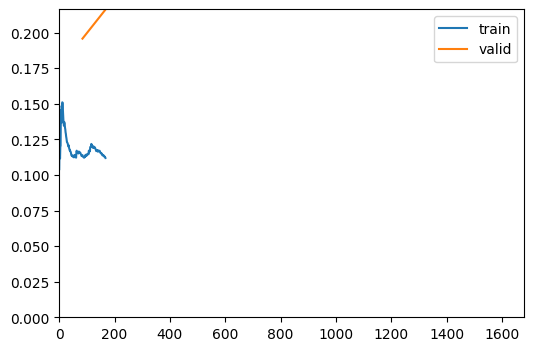

No improvement since epoch 0: early stopping


In [22]:
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

### Validation

In [23]:
learn.validate()

(#6) [0.19572661817073822,0.8801203370094299,0.9302265644073486,0.9344474077224731,0.925713300704956,0.9245439171791077]

### Predictions of the training set

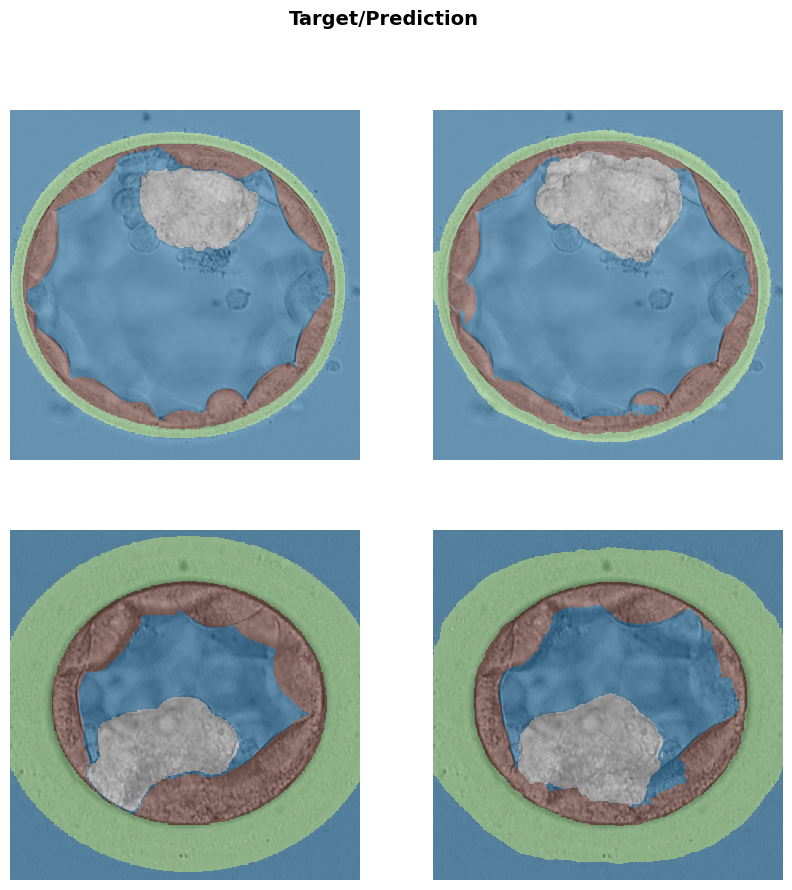

In [24]:
learn.show_results(figsize=(10,10))

### Saving the model

In [25]:
aux=learn.model
aux=aux.cpu()
traced_cell=torch.jit.script(aux)
traced_cell.save("../models/models/deeplab.pth")

### Load the model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.jit.load("../models/models/deeplab.pth")
model = model.cpu()

#### Define prediction function for predicting from a path

In [23]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [24]:
def prediction(path):
    img = PIL.Image.open(path).convert('RGB')
    image = transforms.Resize((480,480))(img)
    tensor = transform_image(image=image)
    model.to(device)
    with torch.no_grad():
        outputs = model(tensor)

    outputs = torch.argmax(outputs,1)
    mask = np.array(outputs.cpu())
    mask[mask==1]=75
    mask[mask==2]=255
    mask[mask==3]=150
    mask=np.reshape(mask,(480,480))
    return np.array(transforms.Resize(img.shape)(Image.fromarray(mask.astype('uint8'))))

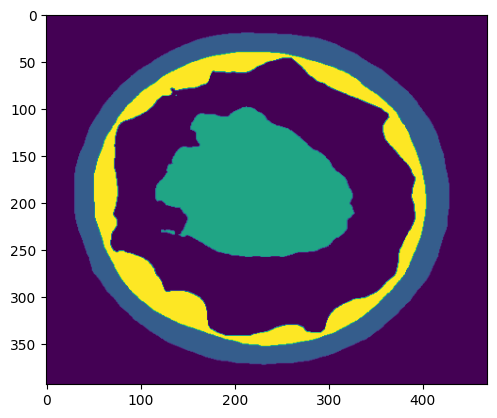

In [8]:
mask=prediction('../dataset/test/Blast_PCRM_R12-0316a.BMP')
img=cv2.imread('../dataset/test/Blast_PCRM_R12-0316a.BMP', cv2.IMREAD_GRAYSCALE)
plt.imshow(mask)

#### Saving the predictions

In [ ]:
os.mkdir('deeplab')

In [33]:
path_save=Path('deeplab')
os.mkdir(path_save)
for f in files:
    pred=prediccion(str(f))
    cv2.imwrite(str(path_save/f.name), pred)

### Evaluation

#### Define the metrics

In [9]:
def accuracy(target, prediction):
    true_detec = np.logical_not(np.logical_xor(target, prediction))
    return np.sum(true_detec)/np.sum(np.ones_like(target))

def precision(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(prediction)

def recall(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(target)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    return 2*np.sum(intersection) / (np.sum(target) + np.sum(prediction))

def metrics(target, prediction):
    return {'accuracy': accuracy(target, prediction),
            'precision': precision(target, prediction),
            'recall': recall(target, prediction),
            'specificity': recall(1-target,1- prediction),
            'jaccard':jaccard(target, prediction),
            'dice': dice(target, prediction)}

def summary_metrics(y_test,predictions):
    a,p,r,s,j,d=0.,0.,0.,0.,0.,0.
    n=len(predictions)
    for i in range(n):
        preds= predictions[i]==255
        gt= y_test[i]==255
        metricas=metrics(gt,preds)
        a+=metricas['accuracy']
        p+=metricas['precision']
        r+=metricas['recall']
        s+=metricas['specificity']
        j+=metricas['jaccard']
        d+=metricas['dice']
    return {'accuracy': a/n,
            'precision': p/n,
            'recall': r/n,
            'specificity': s/n,
            'jaccard':j/n,
            'dice': d/n}

In [10]:
def get_mask(path,string,path_gt):
    file='GT_{}/'.format(string) +path.stem+' {}_Mask.bmp'.format(string)
    path_gt_file=str(path_gt/file)
    return cv2.imread(path_gt_file,cv2.IMREAD_GRAYSCALE)

In [11]:
path_test=path/'test'
files=[path_test/f for f in os.listdir(path_test)]

In [12]:
gtruth_zp=[get_mask(f,'ZP',path) for f in files]
gtruth_te=[get_mask(f,'TE',path) for f in files]
gtruth_icm=[get_mask(f,'ICM',path) for f in files]

In [13]:
preds=[prediction(f) for f in files]

In [14]:
preds_zp=[255*(p==75).astype('uint8') for p in preds]  
preds_te=[255*(p==255).astype('uint8') for p in preds]
preds_icm=[255*(p==150).astype('uint8') for p in preds]  

In [15]:
summary_metrics(gtruth_zp,preds_zp)

{'accuracy': 0.966564766220394,
 'precision': 0.9301274398992352,
 'recall': 0.8317700684422316,
 'specificity': 0.9896798331611091,
 'jaccard': 0.7821263690138487,
 'dice': 0.8728158337751847}

In [16]:
summary_metrics(gtruth_te,preds_te)

{'accuracy': 0.967315007091187,
 'precision': 0.8797702251123954,
 'recall': 0.816311239740769,
 'specificity': 0.9859826600762007,
 'jaccard': 0.7343070494051507,
 'dice': 0.8436504118463489}

In [17]:
summary_metrics(gtruth_icm,preds_icm)

{'accuracy': 0.9825554606802899,
 'precision': 0.8850031708041123,
 'recall': 0.8726949783161091,
 'specificity': 0.9920440832061083,
 'jaccard': 0.7948351459715886,
 'dice': 0.8718984983746324}

### INFERENCE

In [21]:
path_image='../img.png'
mask=prediction(path_image)

In [22]:
img=cv2.imread(path_image)

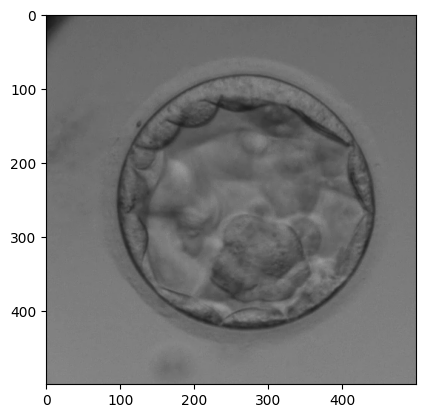

In [23]:
plt.imshow(img)

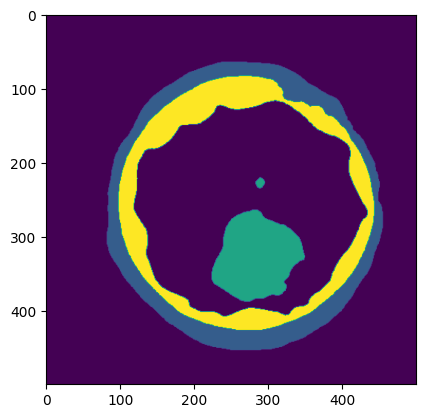

In [24]:
plt.imshow(mask)

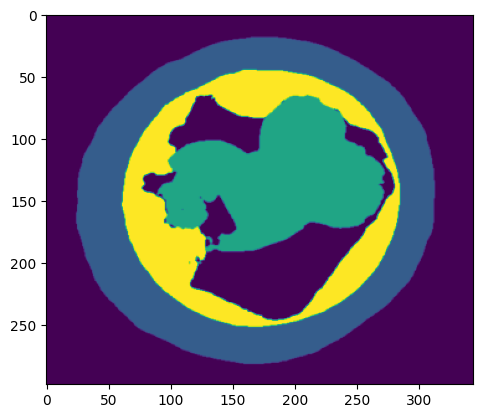

In [49]:
mask=prediction('../dataset/test/Blast_PCRM_d5.17.BMP')
img=cv2.imread('../dataset/test/Blast_PCRM_d5.17.BMP', 1)
plt.imshow(mask)

In [39]:
mask.shape

(298, 344)

In [58]:
mask_rgb=np.zeros_like(img)

In [59]:
mask_rgb[:,:,0][mask==255]=255
mask_rgb[:,:,1][mask==150]=255
mask_rgb[:,:,2][mask==75]=255

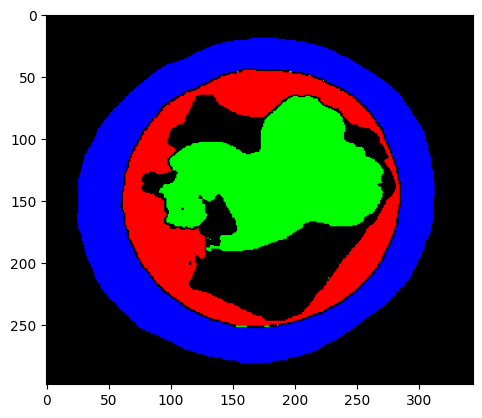

In [60]:
plt.imshow(mask_rgb)

In [61]:
mask_rgb.shape

(298, 344, 3)

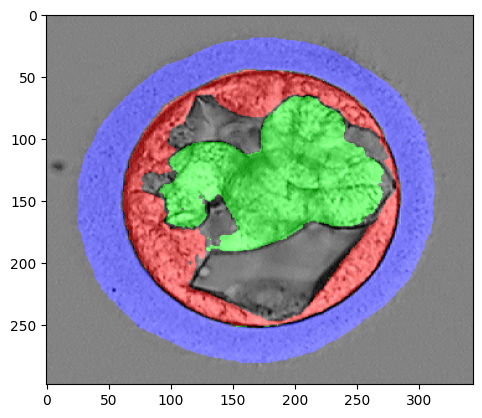

In [62]:
plt.imshow(cv2.addWeighted(img,0.7,mask_rgb,0.5,0))